# Analysing Mesut Ozil's Performance

In [7]:
# import relevant libraries
%matplotlib inline
import json
import matplotlib
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import squarify
from functools import reduce

## Draw the pitch

In [8]:
def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="black")
    plt.plot([0,14.6],[57.8,57.8],color="black")
    plt.plot([0,14.6],[22.2,22.2],color="black")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="black")
    plt.plot([105.4,105.4],[57.8,22.5],color="black")
    plt.plot([120, 105.4],[22.5,22.5],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="black")
    plt.plot([4.9,4.9],[48,32],color="black")
    plt.plot([0,4.9],[32,32],color="black")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="black")
    plt.plot([115.1,115.1],[48,32],color="black")
    plt.plot([120,115.1],[32,32],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)  

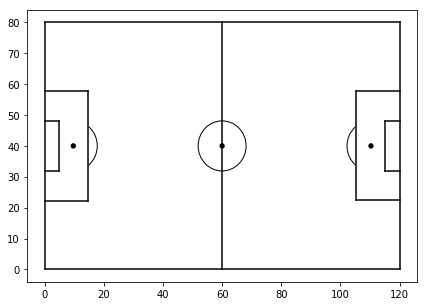

In [9]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.show()

## Passmap

We look at Mesut Ozil's Passes in the match between Germany and South Korea, where he received lots of criticism

In [10]:
# find file
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [11]:
filename = find('7567.json', 
                '/Users/steven/Documents/Developer/data_science/football/data/raw')

# loading the json file
with open(str(filename)) as data_file:    
    data = json.load(data_file)

In [12]:
df = json_normalize(data, sep = "_")
ozil_pass = df[(df['type_name'] == "Pass") & 
               (df['player_name']=='Mesut Özil')] # get passing information of Ozil
pass_column = [i for i in df.columns if i.startswith("pass")]
ozil_pass = ozil_pass[["id", "period", "timestamp", "location", "pass_end_location", "pass_recipient_name"]]
ozil_pass.head()

,id,period,timestamp,location,pass_end_location,pass_recipient_name
4,3fdde45d-6d6a-4094-ab64-63df89f42034,1,00:00:00.187,"[61.0, 41.0]","[49.0, 35.0]",Toni Kroos
10,5a552162-ca1a-44ee-9ad9-0ec68f9920ac,1,00:00:04.200,"[55.0, 43.0]","[37.0, 59.0]",Niklas Süle
112,6571fb69-1b8b-491e-baea-285aabe0e8ff,1,00:02:53.600,"[65.0, 23.0]","[71.0, 27.0]",Marco Reus
129,77e90ffc-8e4d-4351-8bb4-3a9184b1a827,1,00:03:03.517,"[60.0, 25.0]","[56.0, 38.0]",Sami Khedira
143,b74c608d-7182-4d8a-be0f-ac6943e5d70d,1,00:03:15.080,"[67.0, 45.0]","[56.0, 32.0]",Toni Kroos


## Heatmap

In [146]:
# extract players involvement in the entire game
ozil_action = df[(df['player_name']=='Mesut Özil')][["id", "type_name","period", "timestamp", "location"]]
ozil_action.head()

,id,type_name,period,timestamp,location
4,3fdde45d-6d6a-4094-ab64-63df89f42034,Pass,1,00:00:00.187,"[61.0, 41.0]"
9,53bd0dea-3a8c-4815-8631-d08565aea77d,Ball Receipt*,1,00:00:02.960,"[58.0, 42.0]"
10,5a552162-ca1a-44ee-9ad9-0ec68f9920ac,Pass,1,00:00:04.200,"[55.0, 43.0]"
63,77b45d68-597a-41bd-b6bc-068800cde568,Interception,1,00:01:36.080,"[12.0, 28.0]"
111,3a507d88-0576-424d-a052-f97d18cacf88,Ball Receipt*,1,00:02:53.559,"[65.0, 20.0]"


We now put both the heat map and the pass map together, with a nice pitch at the background

In [147]:
def heat_pass_map(data, player_name):
    pass_data = data[(data['type_name'] == "Pass") & (data['player_name'] == player_name)]
    action_data = data[(data['player_name']==player_name)]
    
    fig=plt.figure()
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)
    draw_pitch(ax)
    plt.axis('off')

    for i in range(len(pass_data)):
        # we also differentiate by color
        color = "blue" if pass_data.iloc[i]['period'] == 1 else "red"
        ax.annotate("", xy = (pass_data.iloc[i]['pass_end_location'][0], pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
               xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
               arrowprops = dict(arrowstyle="->",connectionstyle="arc3", color = color),)
    x_coord = [i[0] for i in action_data["location"]]
    y_coord = [i[1] for i in action_data["location"]]
    sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)
    plt.ylim(0, 80) # need this, otherwise kde plot will go outside
    plt.xlim(0, 120)
    plt.show()

### Ozil struggles to play direct, attacking passes

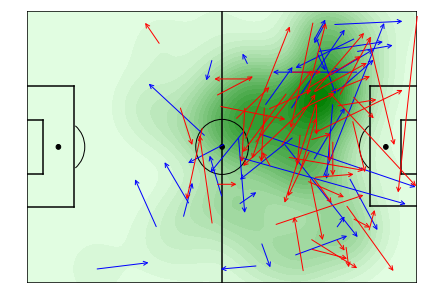

In [148]:
heat_pass_map(df, 'Mesut Özil')

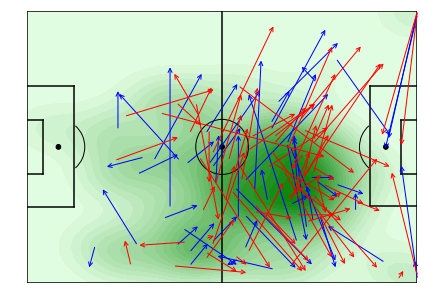

In [149]:
heat_pass_map(df, 'Toni Kroos')

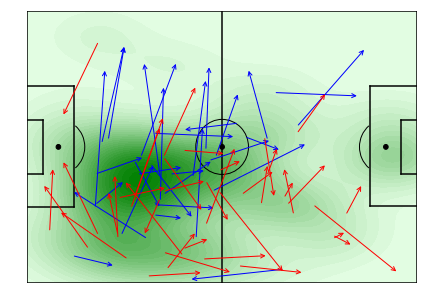

In [150]:
heat_pass_map(df, 'Mats Hummels')